<h1>Part 4 - Modeling</h1> <br/>

**View from 30,000 feet**<br/>
-The objective is **"to quantify and rank the factors that impact passenger satisfaction."** <br/> 
-Among those factors, the ones that we would be most **interested in are the ones that we could exert some control** - i.e. those variables in the survey that are asked to be rated from 1 to 5 (those in "vars_cat_num" in the code).<br/>
-Conceivably, if we could **calibrate a model that would accurately represent passenger satisfaction**, we could **perform sensitivity analysis** around these variables we influence. <br/>
    An example, would be to ask the counterfactual question: **"How would the general satisfaction change if for everyone who rated "Cleanliness" at 3, the "Cleanliness" rating went up to 4?"**<br/>
-If we performed this analysis for every variable, then we would have a predictive output that the rest of the company could use to help guide short- and long-term projects.



**Implementation Steps**<br/>
-Take a look all variables to have an idea about how the final factor importance could look like.<br/>
-Train two ensemble tree models (random forest vs AdaBoost) with cross-validation using grid search for optimal tree depth and decide on one.<br/>
-Retrain the model based on all training data available. <br/>
-Calculate the average impact on satisfaction for all variables at various base levels. <br/>



In [1]:
#import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV

**Import Data and Restate Variables**

In [2]:
train_data_final = pd.read_pickle('data/model/train_data_final.pkl')
test_data_final = pd.read_pickle('data/model/test_data_final.pkl')
print(test_data_final.isna().sum())

vars_cont = ['Age', 'Flight Distance', 'Arrival Delay in Minutes', 'Departure Delay in Minutes']

vars_cat_num = ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness']

vars_cat_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
Relative Arrival Delay               0
dtype: int64


**A Correlation Analysis Before Running A Tree-Based Model**<br/>
This will help us visualize the problem space.


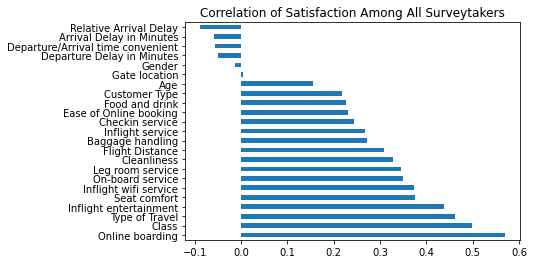

In [3]:
feat_corr_with_sat = train_data_final.corr()['satisfaction'].sort_values(ascending=False).drop(['satisfaction'])
feat_corr_with_sat.plot(kind='barh')
plt.title('Correlation of Satisfaction Among All Surveytakers'); print()

**Use Random Forests to Calibrate the Training Set**<br/>

In [4]:
max_depth_param = 15
param_grid_rf = {'max_depth':list(range(1, max_depth_param + 1))}
clf_rf = RandomForestClassifier()

scorer= {'f1_score':make_scorer(f1_score), 
             'precision_score':make_scorer(precision_score),
             'recall_score':make_scorer(recall_score),
             'accuracy_score':make_scorer(accuracy_score)}
clf_rf_cv = GridSearchCV(clf_rf, param_grid_rf, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
#clf_rf_cv.fit(train_data_final.drop(['satisfaction', 'Gender', 'Gate location'], axis=1),train_data_final['satisfaction']);
clf_rf_cv.fit(train_data_final.drop(['satisfaction'], axis=1),train_data_final['satisfaction']);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


In [5]:
clf_rf_cv_results = pd.DataFrame(clf_rf_cv.cv_results_)

**Use Ada Boost to Calibrate the Training Set**<br/>

In [6]:
param_grid_ada = {'base_estimator__max_depth':list(range(1, max_depth_param + 1)), 'n_estimators':[100]}
clf_tree = DecisionTreeClassifier()
clf_ada = AdaBoostClassifier(clf_tree)
clf_ada_cv = GridSearchCV(clf_ada, param_grid_ada, cv=5, n_jobs=-1, scoring = scorer, refit='f1_score', verbose=3)
clf_ada_cv.fit(train_data_final.drop(['satisfaction'], axis=1),train_data_final['satisfaction'])
#clf_ada_cv.fit(train_data_final.drop(['satisfaction', 'Gender', 'Gate location'], axis=1),train_data_final['satisfaction'])

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15],
                         'n_estimators': [100]},
             refit='f1_score',
             scoring={'accuracy_score': make_scorer(accuracy_score),
                      'f1_score': make_scorer(f1_score),
                      'precision_score': make_scorer(precision_score),
                      'recall_score': make_scorer(recall_score)},
             verbose=3)

In [7]:
clf_ada_cv_results = pd.DataFrame(clf_ada_cv.cv_results_)

**Decide on the Model**<br/>

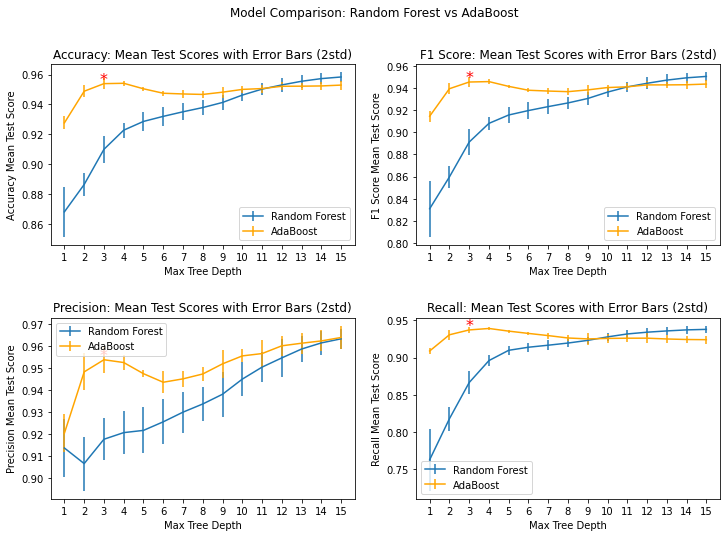

In [8]:
clf_rf_cv_results['Method'] = 'RF'
clf_rf_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))

clf_ada_cv_results['Method'] = 'AdaBoost'
clf_ada_cv_results['Max Tree Depth'] = list(range(1, max_depth_param+1))


combined_cv_results = pd.concat([clf_rf_cv_results, clf_ada_cv_results])
#print(combined_cv_results)

score_list = [[['mean_test_accuracy_score', 'std_test_accuracy_score', 'Accuracy'],
               ['mean_test_f1_score', 'std_test_f1_score', 'F1 Score']],
              [['mean_test_precision_score', 'std_test_precision_score', 'Precision'],
               ['mean_test_recall_score', 'std_test_recall_score', 'Recall']]]

# ax = sns.catplot(data = combined_cv_results, 
#            x = 'Max Tree Depth',
#            y = 'mean_test_score',
#            hue = 'Method',
#            ci = 'std_test_score')
def plot_scores_rf_ada(df, score_var_name, error_var_name, scorer_name, ax):
    rng = len(df)//2
    ax.errorbar(list(range(0,rng)), 
                 combined_cv_results[combined_cv_results['Method']=='RF'][score_var_name],
                yerr = 2*combined_cv_results[combined_cv_results['Method']=='RF'][error_var_name])
    ax.errorbar(list(range(0,rng)), 
                 combined_cv_results[combined_cv_results['Method']=='AdaBoost'][score_var_name],
                yerr = 2*combined_cv_results[combined_cv_results['Method']=='AdaBoost'][error_var_name],
                color = 'orange')
    ax.set_xticks(range(0, 15))
    ax.set_xticklabels(range(1, 16))
    ax.set_xlabel('Max Tree Depth')
    ax.set_ylabel(scorer_name+' Mean Test Score')
    ax.legend(['Random Forest', 'AdaBoost'])
    ax.set_title(scorer_name+': Mean Test Scores with Error Bars (2std)')
    
combined_cv_results
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12, 8)
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Model Comparison: Random Forest vs AdaBoost")

for _i in range(0, 2):
    for _j in range(0, 2):
        plot_scores_rf_ada(combined_cv_results, 
                           score_list[_i][_j][0], 
                           score_list[_i][_j][1], 
                           score_list[_i][_j][2], 
                           ax[_i][_j])
        ax[_i][_j].annotate(text = '*', size=16,
                            xy=[1.8, combined_cv_results[combined_cv_results['Method']=='AdaBoost'][score_list[_i][_j][0]][2]], color = 'red')

Although, the models seem to behave similarly in terms of scores at higher Max Tree Depth values, we see that the AdaBoost with lower Max Tree Depth values shows a similar performance to the higher end models.</br> Given the parsimony of these low Max Tree Depth AdaBoost models, we choose an AdaBoost model - particularly the one with depth 3.

**Retrain On All Available Training Data and Display Feature Importance**<br/>

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'Relative Arrival Delay'],
      dtype='object')
satisfaction
23
23
Importance    1.0
dtype: float64



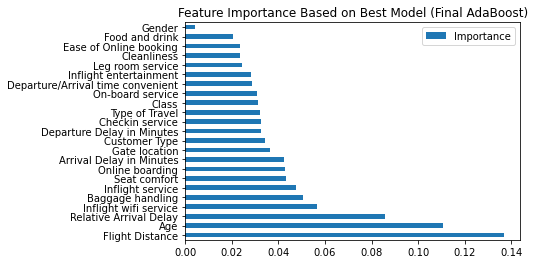

In [9]:
clf_best_tree = DecisionTreeClassifier(max_depth=4)
clf_best = AdaBoostClassifier(clf_best_tree, n_estimators=100)
#clf_best = RandomForestClassifier(max_depth=14)
##train_X = train_data_final.drop(['satisfaction', 'Gender', 'Gate location'], axis=1)
train_X = train_data_final.drop(['satisfaction'], axis=1)
print(train_X.columns)
train_y = train_data_final['satisfaction']
print(train_y.name)

clf_best.fit(train_X,train_y)
print(clf_best.n_features_in_)
print(len(clf_best.feature_importances_))

feature_df = pd.DataFrame(data={'Importance':clf_best.feature_importances_}, index=train_X.columns)
print(feature_df.sum())
feature_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_df.plot(kind='barh')

plt.title('Feature Importance Based on Best Model (Final AdaBoost)'); print()

In [22]:
print('Final Model (AdaBoost) Scores')
print('Accuracy:  {0:.3f}'.format(accuracy_score(test_data_final['satisfaction'], clf_best.predict(test_data_final.drop(['satisfaction'], axis=1)))))
print('F1 Score:  {0:.3f}'.format(f1_score(test_data_final['satisfaction'], clf_best.predict(test_data_final.drop(['satisfaction'], axis=1)))))
print('Precision: {0:.3f}'.format(precision_score(test_data_final['satisfaction'], clf_best.predict(test_data_final.drop(['satisfaction'], axis=1)))))
print('Recall:    {0:.3f}'.format(recall_score(test_data_final['satisfaction'], clf_best.predict(test_data_final.drop(['satisfaction'], axis=1)))))

Final Model (AdaBoost) Scores
Accuracy:  0.955
F1 Score:  0.948
Precision: 0.954
Recall:    0.942


**Quantify and Rank Factors that Impact Customer Satisfaction**<br/>

Let's imagine the following experiment: <br/>
If all the passengers who marked Cleanliness Category as 3 (out of 5) were to increase their scores to 4, how would this group's average satisfaction change?<br/>
Taking the argument one step futher, we can also estimate how overall satisfaction would change if the average score, say, in Cleanliness Category, were to increase by 0.5. <br/> <br/>
These datapoints, coupled with some other data, say, cost of improving these factors, could lead the company to prioritize initiatives.



In [11]:
#build a model on relative delay (and flight characteristics (distance)) for prospective deployments

In [91]:
levels = [1,2,3,4,5]

#generate a df that holds satisfaction percentages conditional on survey scores.
base_df = pd.DataFrame(data = np.nan, columns=vars_cat_num, index=levels)

#generate a df that holds the experiment results where category score increases by 1
increase_df = base_df.copy() 


for cat in vars_cat_num:
    _ = test_data_final.groupby(cat).mean()['satisfaction'].sort_index()
    base_df[cat]=_

def increase_by_one(df, cat, lvl):
    '''Increase the score of a certain survey category by 1 while scores on the rest 
    of the categories are unchanged. Return the new population.'''
    _ = df[df[cat] == lvl]
    _inc = _.copy()
    _inc[cat] = _inc[cat] + 1
    return _inc#.drop(['Gender', 'Gate location'], axis=1)

#Run the experiment for each category score that one could increase
for lvl in [1,2,3,4]:
    for cat in vars_cat_num:
        _ = increase_by_one(train_data_final, cat, lvl).drop(['satisfaction'], axis=1)
        increase_df.loc[lvl][cat] = clf_best.predict(_).mean()

#create a dataframe representing the average satisfaction change for each experiment 
#(i.e. all Category and level pairs)
inc_sat_chg_df = increase_df - base_df

print('Base Mean Satisfaction')
pd.set_option('display.float_format',  '{:.1%}'.format)
base_df



Base Mean Satisfaction


,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,36.4%,50.2%,39.5%,50.6%,16.8%,12.5%,19.5%,10.7%,17.9%,17.1%,27.7%,22.3%,27.1%,17.2%
2,25.3%,44.2%,31.2%,46.5%,37.9%,10.6%,20.2%,17.5%,23.8%,25.6%,26.8%,23.2%,27.5%,18.0%
3,26.8%,44.2%,32.6%,33.4%,39.7%,14.2%,20.7%,26.4%,30.2%,26.5%,23.0%,45.2%,22.7%,43.1%
4,61.1%,38.3%,53.3%,38.9%,52.7%,61.9%,55.6%,61.4%,52.4%,58.6%,47.6%,45.3%,47.6%,53.4%
5,98.7%,41.3%,71.0%,55.1%,55.4%,86.7%,65.8%,66.6%,67.2%,62.0%,63.3%,62.1%,62.1%,63.1%


The above table shows the base case where each cell represents the average satisfaction based on category and survey score.

In [94]:
print("Experiment Result")
print("(e.g. (Inflight wifi service, 4) refers to the experiment where Base Score of 4 was increased to 5:\n{0:.1%} to {1:.1%}".format(base_df['Inflight wifi service'][4], increase_df['Inflight wifi service'][4] ))
increase_df

Experiment Result
(e.g. (Inflight wifi service, 4) refers to the experiment where Base Score of 4 was increased to 5:
61.1% to 87.8%


,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,34.0%,48.7%,37.6%,19.3%,17.0%,12.9%,18.5%,9.2%,15.6%,16.4%,24.9%,22.5%,24.8%,16.5%
2,25.1%,43.6%,31.4%,44.3%,37.0%,10.2%,18.0%,17.6%,23.3%,24.1%,25.5%,24.4%,25.7%,17.4%
3,38.8%,42.4%,31.4%,32.8%,38.0%,15.6%,18.8%,23.4%,28.2%,25.2%,22.1%,43.4%,22.3%,41.6%
4,87.8%,37.0%,52.0%,36.4%,52.2%,69.0%,62.4%,60.3%,56.7%,58.1%,54.4%,52.1%,51.6%,69.6%
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The table above is the "Experiment" result which represents how an increase in survey score in a single category translates to average satisfaction.

In [95]:
inc_sat_chg_df

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,-2.4%,-1.5%,-1.9%,-31.3%,0.2%,0.3%,-1.0%,-1.5%,-2.3%,-0.8%,-2.8%,0.2%,-2.3%,-0.7%
2,-0.2%,-0.7%,0.1%,-2.2%,-0.9%,-0.5%,-2.3%,0.1%,-0.5%,-1.5%,-1.3%,1.2%,-1.8%,-0.6%
3,12.0%,-1.8%,-1.2%,-0.7%,-1.7%,1.4%,-1.9%,-3.0%,-2.0%,-1.4%,-0.9%,-1.8%,-0.5%,-1.5%
4,26.7%,-1.3%,-1.3%,-2.5%,-0.4%,7.2%,6.7%,-1.1%,4.3%,-0.5%,6.8%,6.8%,4.0%,16.2%
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Represents the net average satisfaction change for each "experiment". 
Coupled with weights in the survey, this dataframe can help estimate changes in average satisfaction given an improvement initiative in a category.


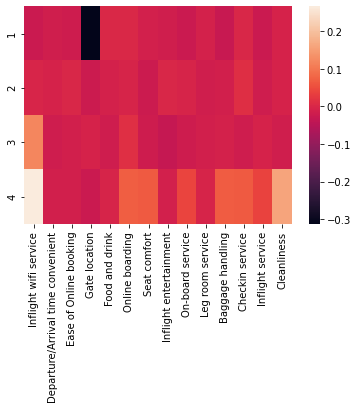

In [96]:
sns.heatmap(data =inc_sat_chg_df.loc[:4,:]);


In the above, lighter colors point to larger increases in average satisfaction given a unit increase in survey response. <br/>
In the next part, we will see the aggreage impact of these individual increases per category.

**Impact on Average Satisfaction Given Unit Increases in Each Category**<br/>

Let's complete our experiment by increasing each survey response by 1 where possible and observing the change in average satisfaction. <br/>

In [97]:
#Generate survey weights from test data. This gives an idea of the score distribution in each category.
survey_weights_test = pd.DataFrame()
for cat in vars_cat_num:
    _ = train_data_final[cat].value_counts(normalize=True)
    survey_weights_test[cat] = _

survey_weights_test.sort_index()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness
1,17.3%,15.9%,17.6%,16.8%,12.2%,10.4%,11.3%,11.6%,11.3%,9.8%,6.7%,12.6%,6.5%,12.7%
2,25.8%,17.7%,24.3%,18.7%,21.2%,17.3%,14.1%,16.7%,14.2%,18.6%,11.0%,12.6%,11.0%,15.4%
3,25.9%,18.4%,24.7%,27.3%,21.4%,21.6%,18.0%,18.2%,21.7%,19.3%,20.2%,27.4%,19.8%,23.7%
4,19.6%,25.6%,19.6%,23.4%,23.7%,30.4%,31.0%,29.0%,30.0%,28.3%,36.3%,28.0%,36.8%,26.4%
5,11.4%,22.4%,13.9%,13.7%,21.5%,20.2%,25.6%,24.6%,22.7%,24.0%,25.8%,19.5%,25.8%,21.9%


Following cell runs our experiment based on the above weight data:

In [98]:
unit_inc_experiment_result = pd.DataFrame((survey_weights_test*up_diff).sum().sort_values(ascending=False), columns = ['Experiment Impact'])
unit_inc_experiment_result['Baseline Satisfaction'] = test_data_final['satisfaction'].mean()
unit_inc_experiment_result['Satisfaction After Experiment'] = unit_inc_experiment_result['Experiment Impact'] + unit_inc_experiment_result['Baseline Satisfaction']
pd.set_option('display.float_format',  '{:.1%}'.format)
unit_inc_experiment_result

,Experiment Impact,Baseline Satisfaction,Satisfaction After Experiment
Inflight wifi service,7.9%,43.0%,50.9%
Cleanliness,3.8%,43.0%,46.8%
Online boarding,2.4%,43.0%,45.5%
Baggage handling,2.0%,43.0%,45.0%
Checkin service,1.6%,43.0%,44.6%
Seat comfort,1.3%,43.0%,44.3%
Inflight service,1.0%,43.0%,44.1%
On-board service,0.5%,43.0%,43.6%
Food and drink,-0.6%,43.0%,42.4%
Leg room service,-0.8%,43.0%,42.3%


The above experiment indicates that "Inflight wifi service" and "Cleanliness" could be the most important factors in increasing the average satisfaction rate.<br/><br/>
A suggestion for the company is to prioritize improvements in the above two categories.
